# **Bioinformatics and Machine Learning: Cancer Classifier Project**

## Online Tutorial by Darko Mediin

*https://darkodatasci.hashnode.dev/bioinformatics-and-machine-learning-cancer-classifier-project-l*

@author: 2pitesh

Link to database:
*https://www.ebi.ac.uk/gxa/experiments/E-MTAB-2770/Downloads*

### **Refrences:**
Barretina J, Caponigro G, Stransky N, Venkatesan K, Margolin AA et al. (2012) The Cancer Cell Line Encyclopedia enables predictive modelling of anticancer drug sensitivity.

Ghandi M, Huang FW, Jané-Valbuena J, Kryukov GV, Lo CC et al. (2019) Next-generation characterization of the Cancer Cell Line Encyclopedia.

**Goal:**
Create a classification model that predicts leukemia separate from other cancers based on cell line gene expression.

In [11]:
# import relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle


### Examine the gene expression dataset

Since we're only classifying leukemia vs non-leukemia, we want to avoid normal cells being classified as non-leukemia so we remove those columns

In [13]:
df = pd.read_csv("E-MTAB-2770-query-results.tpms.tsv", sep='\t', comment='#')
df = df.loc[:,~df.columns.str.contains('normal', case=False)] # use to remove the columns that have normal in their name (normal cell lines)
df.head()

,Gene ID,Gene Name,"22Rv1, prostate carcinoma","23132/87, gastric adenocarcinoma","253J, bladder carcinoma","253J-BV, bladder carcinoma","42-MG-BA, glioblastoma","5637, bladder carcinoma","59M, high grade ovarian serous adenocarcinoma","639-V, ureter urothelial carcinoma",...,"WSU-DLCL2, diffuse large B-cell lymphoma","YAPC, pancreatic carcinoma","YD-10B, tongue squamous cell carcinoma","YD-15, tongue squamous cell carcinoma","YD-38, head and neck squamous cell carcinoma","YD-8, tongue squamous cell carcinoma","YH-13, glioblastoma","YKG1, glioblastoma","ZR-75-1, invasive ductal carcinoma","ZR-75-30, invasive ductal carcinoma"
0,ENSG00000000003,TSPAN6,7.0,10.0,29.0,33.0,33.0,86.0,23.0,45.0,...,0.7,71.0,15.0,31.0,30.0,60.0,39.0,84.0,14.0,23.0
1,ENSG00000000005,TNMD,NaN,NaN,0.1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ENSG00000000419,DPM1,151.0,238.0,94.0,132.0,223.0,222.0,182.0,286.0,...,113.0,239.0,171.0,206.0,208.0,252.0,136.0,235.0,374.0,120.0
3,ENSG00000000457,SCYL3,17.0,27.0,5.0,5.0,5.0,6.0,4.0,5.0,...,11.0,11.0,5.0,5.0,6.0,8.0,10.0,11.0,32.0,21.0
4,ENSG00000000460,C1orf112,24.0,12.0,4.0,9.0,9.0,27.0,9.0,11.0,...,19.0,11.0,7.0,13.0,23.0,8.0,12.0,15.0,20.0,11.0


### Define the target variable

In this case the targets are the cancer types (columns). So we can assign those to a list

In [15]:
# Define the targets for prediction (cancer samples)
target = list(df.columns[2:]) # 1st and 2nd cols are 'Gene ID' and 'Gene Name'; we don't want those as part of the target list
target

['22Rv1, prostate carcinoma',
 '23132/87, gastric adenocarcinoma',
 '253J, bladder carcinoma',
 '253J-BV, bladder carcinoma',
 '42-MG-BA, glioblastoma',
 '5637, bladder carcinoma',
 '59M, high grade ovarian serous adenocarcinoma',
 '639-V, ureter urothelial carcinoma',
 '647-V, bladder transitional cell carcinoma',
 '697, B-cell acute lymphoblastic leukemia',
 '769-P, renal cell carcinoma',
 '786-O, renal cell carcinoma',
 '8-MG-BA, glioblastoma',
 '8305C, thyroid gland undifferentiated (anaplastic) carcinoma',
 '8505C, thyroid gland undifferentiated (anaplastic) carcinoma',
 'A-204, embryonal rhabdomyosarcoma',
 'A-253, salivary gland squamous cell carcinoma',
 'A-375, amelanotic melanoma',
 'A-498, renal cell carcinoma',
 'A-673, Ewing sarcoma',
 'A-704, renal cell carcinoma',
 'A101D, melanoma',
 'A1207, glioblastoma',
 'A172, glioblastoma',
 'A2058, amelanotic melanoma',
 'A2780, ovarian endometrioid adenocarcinoma',
 'A3/KAW, diffuse large B-cell lymphoma',
 'A4/Fuk, B-cell acute 

In [17]:
# function that changes the names of the labels to the way we want it (engineered labels)
def eng_labels(x):
    labs = [] # empty list to store the names
    for s in x: # iterate throught the target array
        if 'leukemia' in s: # check to see if 'leukemia' is in the array values
            labs.append('leukemia') #label it as leukemia
        else:
            labs.append('other cancers')
    return(labs)

labs = eng_labels(target)
labs = ['Gene'] + labs # add the description of the list to the beginning
labs = pd.Series(labs)
labs

0                Gene
1       other cancers
2       other cancers
3       other cancers
4       other cancers
            ...      
1007    other cancers
1008    other cancers
1009    other cancers
1010    other cancers
1011    other cancers
Length: 1012, dtype: object

### Transpose the dataset

Most programs read the columns as variables and rows as samples.

So we want the genes to be the variables that predict whether the cell line is leukemia or not.

Therefore, we transpose the dataset so that the genes are columns and the cancers are samples

In [25]:
data = df.iloc[:,1:] # select all the rows starting from the 2nd column (indx 1) and onward
data.columns = labs # add the new column names ('leukemia' vs 'other cancers') to replace the cancer descriptors
data = data.transpose() # transpose the data set so that the old columns become samples (keeps indexes as column headers)
data.columns = data.loc['Gene',:] # the new columns are all the columns found in the 'Gene' row (gene names)
data = data.iloc[1:,:] # select all the rows starting from 2nd row (indx 1) and all the columns
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
data.head(20) # display only a subset of the data

Gene,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,LINC02689,ENSG00000285986,ENSG00000285987,ENSG00000285988,H2AQ1P,NBEAP6,ENSG00000285991,ENSG00000285992,ENSG00000285993,ENSG00000285994
other cancers,7.0,NaN,151.0,17.0,24.0,NaN,0.1,100.0,124.0,95.0,...,NaN,NaN,NaN,NaN,NaN,0.4,0.1,0.3,NaN,NaN
other cancers,10.0,NaN,238.0,27.0,12.0,NaN,0.4,325.0,101.0,48.0,...,NaN,NaN,0.1,NaN,NaN,NaN,0.1,NaN,NaN,NaN
other cancers,29.0,0.1,94.0,5.0,4.0,NaN,0.3,76.0,16.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN
other cancers,33.0,NaN,132.0,5.0,9.0,NaN,0.1,60.0,20.0,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN
other cancers,33.0,NaN,223.0,5.0,9.0,NaN,0.4,99.0,8.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN
other cancers,86.0,NaN,222.0,6.0,27.0,0.3,2.0,138.0,11.0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN
other cancers,23.0,NaN,182.0,4.0,9.0,NaN,9.0,123.0,38.0,47.0,...,NaN,NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN,NaN
other cancers,45.0,NaN,286.0,5.0,11.0,NaN,15.0,151.0,23.0,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.2,NaN,NaN,0.1
other cancers,85.0,NaN,195.0,4.0,14.0,NaN,0.3,109.0,20.0,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN
leukemia,0.2,NaN,101.0,11.0,22.0,0.1,0.2,0.4,19.0,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,0.2


### Exploritory Data Analysis

<AxesSubplot:xlabel='SCYL3', ylabel='Count'>

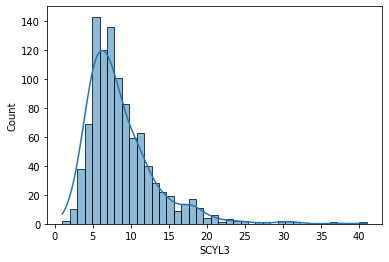

In [26]:
sns.histplot(data['SCYL3'], kde=True)

The SCYL3 gene as a right skewed distribution despite the tpm normalization done before we imported the data.

This negative binomial distribution is typical for RNA seq data.

<AxesSubplot:xlabel='DPM1', ylabel='Count'>

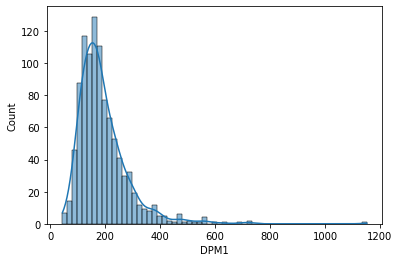

In [27]:
sns.histplot(data['DPM1'], kde=True)

<AxesSubplot:xlabel='MSMO1', ylabel='Count'>

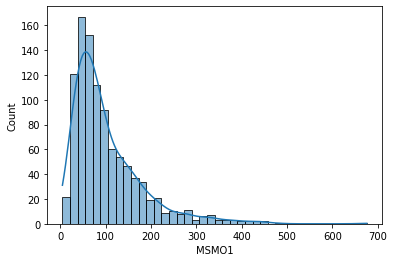

In [28]:
sns.histplot(data['MSMO1'], kde=True)

### Data Engineering to Prep for Machine Learning

1. Perform the label encoding (represents the classes 'leukemia'=0 vs 'other cancers'=1; use label encoder from sklearn)
2. Impute the missing values (use KNN from sklearn)

In [31]:
data_x = data
data_x = np.array(data_x) # contains predictor genes (doesn't include the genes names and row labels) as an array
le = LabelEncoder()
le.fit(data.index)
data_y = le.transform(data.index)
data_y = pd.Series(data_y) # contains labels as 0s and 1s

### Apply Machine Learning Model

Tree-based Classifier method which should perform well on a alarge number of variables with skewed normalized data.

LGBM (light gradient-bosting machine) is a method that can produce high accuracy with skewed data with many variables while simultaneously training quickly in a lot of epochs.

In [32]:
xtrain, xtest, ytrain, ytest = train_test_split(data_x, data_y, test_size=0.33, random_state=87)

# this is needed to facilitate the training process
xtrain = np.array(xtrain, dtype=np.float32)
ytrain = np.array(ytrain, dtype=np.float32)

xtrain, ytrain = shuffle(xtrain, ytrain)
xtest, ytest = shuffle(xtest, ytest)

In [ ]:
# LGBM parameters stored in a dictionary
p={ 'boosting':'dart', 'learning_rate':0.01, 'objective':'binary', 'max_depth':6
   , 'num_leaves':102, 'min_data_in_leaf':35, 'bagging_fraction':1,'device_type':'cpu',
   'feature_fraction':1, 'verbose':0, 'bagging_freq':7, 'extra_trees':'true','cegb_tradeoff':5,
  'max_bin':100, 'min_data_in_bin':2,'n_estimators':15750}


# Train the LGBMClassifier model
lgbmodel = LGBMClassifier(**p).fit(xtrain, ytrain) # properly import the LGBMClassifier

### Using the model to predict new values

In [ ]:
predictions = lgbmodel.predict(xtest)
rpreds = [round(i) for i in predictions] # use round() function to convert to the most probable predicted classes
accuracy = accuracy_score(ytest, rpreds)
accuracy

In [ ]:
# confusion matrix
cm = confusion_matrix(ytest, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
importances = lgbmodel.feature_importances_
importances = pd.Series(importances)
importances.index =data.columns
importances = importances.sort_values(ascending=False)
importances[0:29].to_csv(r'important_genes.csv', sep='\t', header='true')
